In [44]:
import keys
import datetime
from time import sleep
from binance.client import Client

In [45]:
client = Client(keys.APIKey, keys.SecretKey)

### 1. Getting historical value

In [70]:
symbol = 'BTCUSDT'
data = client.get_historical_klines(symbol=symbol, interval='30m', start_str='1 May, 2019')

In [71]:
len(data)

2244

In [76]:
cols = [i for i in range(1, 13)]
cols = ['open_time', 'open', 'high', 'low', 'close',
       'volume', 'close_time', 'quote_asset_vol', 'num_traders',
       'taker_buy_base', 'taker_buy_quote', 'ignore']

In [77]:
cols

['open_time',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'close_time',
 'quote_asset_vol',
 'num_traders',
 'taker_buy_base',
 'taker_buy_quote',
 'ignore']

In [69]:
data[0]

[1557014400000,
 '5829.83000000',
 '5839.90000000',
 '5760.00000000',
 '5776.14000000',
 '1533.05555200',
 1557016199999,
 '8884538.54239760',
 8649,
 '810.56152200',
 '4700565.42462911',
 '0']

In [78]:
import pandas as pd

def csvDf(dat,**kwargs): 
  from numpy import array
  data = array(dat)
  if data is None or len(data)==0 or len(data[0])==0:
    return None
  else:
    return pd.DataFrame(data[0:,0:],index=None,columns=cols,**kwargs)

In [81]:
df = csvDf(data)

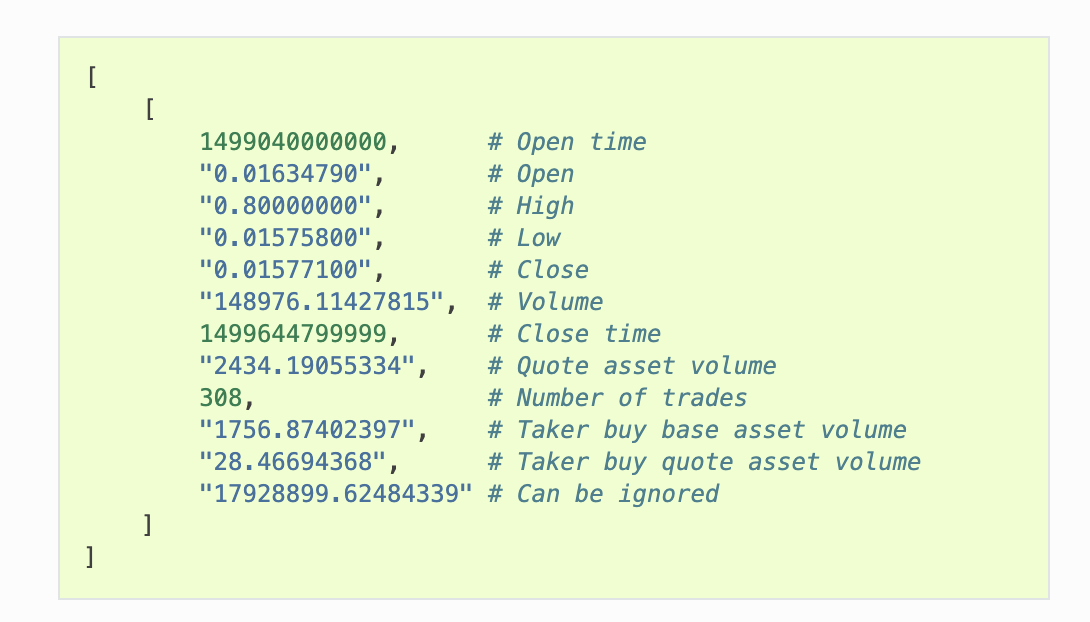

In [80]:
from IPython.display import Image
Image("API_response.png")

# to drop 'open_time', 'quote_asset_vol', 'num_traders','taker_buy_base', 'taker_buy_quote', 'ignore'
# close price might be useful

In [84]:
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_vol,num_traders,taker_buy_base,taker_buy_quote,ignore
0,1556668800000,5321.94000000,5358.13000000,5316.20000000,5338.21000000,923.92114100,1556670599999,4931668.72761859,6966,643.52153900,3435661.80265802,0
1,1556670600000,5338.16000000,5348.00000000,5327.43000000,5335.62000000,438.24464300,1556672399999,2339819.49816355,4530,245.31836700,1309911.62261568,0
2,1556672400000,5335.66000000,5347.47000000,5325.83000000,5331.45000000,371.33607700,1556674199999,1982774.76387494,3817,200.73610000,1071908.90867962,0
3,1556674200000,5331.45000000,5342.32000000,5328.90000000,5338.85000000,260.14569700,1556675999999,1388383.91813497,3385,144.19398200,769582.47592071,0
4,1556676000000,5337.57000000,5374.18000000,5337.57000000,5359.04000000,677.96764800,1556677799999,3631810.53853429,4952,433.21498300,2320800.63577023,0


In [90]:
price = df[['close']]

In [168]:
def price_matrix_creator(data, seq_len=30):
    '''
    It converts the series into a nested list where every item of the list contains historic prices of 30 days
    '''
    price_matrix = []
    for index in range(len(data)-seq_len+1):
        price_matrix.append(data[index:index+seq_len])
    return price_matrix

def normalize_windows(window_data):
    '''
    It normalizes each value to reflect the percentage changes from starting point
    '''
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def train_test_split_(price_matrix, train_size=0.9, shuffle=False, return_row=True):
    '''
    It makes a custom train test split where the last part is kept as the training set.
    '''
    price_matrix = np.array(price_matrix)
    #print(price_matrix.shape)
    row = int(round(train_size * len(price_matrix)))
    train = price_matrix[:row, :]
    if shuffle==True:
        np.random.shuffle(train)
    X_train, y_train = train[:row,:-1], train[:row,-1]
    X_test, y_test = price_matrix[row:,:-1], price_matrix[row:,-1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    if return_row:
        return row, X_train, y_train, X_test, y_test
    else:
        X_train, y_train, X_test, y_test


In [144]:
price.head()

,close
0,5338.21000000
1,5335.62000000
2,5331.45000000
3,5338.85000000
4,5359.04000000


In [151]:
type(df['close'])

pandas.core.series.Series

In [102]:
price.dtypes

close    object
dtype: object

In [156]:
price2 = df['close'].apply(pd.to_numeric, errors='coerce')

In [160]:
price2.dropna(inplace=True)

In [162]:
price2.values

array([5338.21, 5335.62, 5331.45, ..., 9098.51, 9134.4 , 9201.  ])

In [163]:
price_matrix = price_matrix_creator(price2.values) # Creating a matrix using the dataframe

In [167]:
for window in price_matrix:
    normalised_window = [((float(p) / float(window[0])) - 1) for p in window]

In [169]:
price_matrix = normalize_windows(price_matrix) # Normalizing its values to fit to RNN

In [170]:
row, X_train, y_train, X_test, y_test = train_test_split_(price_matrix)
# Applying train-test splitting, also returning the splitting-point

In [171]:
X_train

array([[[ 0.        ],
        [-0.00048518],
        [-0.00126634],
        ...,
        [ 0.00164849],
        [ 0.00270315],
        [ 0.00286988]],

       [[ 0.        ],
        [-0.00078154],
        [ 0.00060537],
        ...,
        [ 0.00318988],
        [ 0.00335669],
        [ 0.0024402 ]],

       [[ 0.        ],
        [ 0.00138799],
        [ 0.00517495],
        ...,
        [ 0.00414146],
        [ 0.00322426],
        [ 0.00429902]],

       ...,

       [[ 0.        ],
        [-0.00397547],
        [ 0.00038476],
        ...,
        [ 0.00627519],
        [ 0.00845973],
        [ 0.01063668]],

       [[ 0.        ],
        [ 0.00437763],
        [ 0.00195056],
        ...,
        [ 0.01248483],
        [ 0.01467047],
        [ 0.01333748]],

       [[ 0.        ],
        [-0.0024165 ],
        [-0.00726468],
        ...,
        [ 0.01024798],
        [ 0.0089208 ],
        [ 0.00741144]]])

## 2. Bulding RNN model

In [172]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import time
# LSTM Model parameters, I chose
batch_size = 2            # Batch size (you may try different values)
epochs = 15               # Epoch (you may try different values)
seq_len = 30              # 30 sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'linear'     # Linear activation
input_shape=(None,1)      # Input dimension
output_dim = 30           # Output dimension

Using TensorFlow backend.


In [174]:
model = Sequential()
model.add(LSTM(units=output_dim, return_sequences=True, input_shape=input_shape))
model.add(Dense(units=32,activation=activation))
model.add(LSTM(units=output_dim, return_sequences=False))
model.add(Dense(units=1,activation=activation))
model.compile(optimizer=optimizer,loss=loss)

Instructions for updating:
Colocations handled automatically by placer.


In [175]:
start_time = time.time()
model.fit(x=X_train,
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)
end_time = time.time()
processing_time = end_time - start_time

Instructions for updating:
Use tf.cast instead.
Train on 1894 samples, validate on 100 samples
Epoch 1/15
1894/1894 [==============================] - 32s 17ms/step - loss: 1.5983e-04 - val_loss: 2.3304e-05
Epoch 2/15
1894/1894 [==============================] - 31s 16ms/step - loss: 7.7153e-05 - val_loss: 5.5015e-05
Epoch 3/15
1894/1894 [==============================] - 31s 16ms/step - loss: 6.6311e-05 - val_loss: 1.5047e-05
Epoch 4/15
1894/1894 [==============================] - 30s 16ms/step - loss: 5.9543e-05 - val_loss: 1.0791e-04
Epoch 5/15
1894/1894 [==============================] - 30s 16ms/step - loss: 5.8157e-05 - val_loss: 3.0393e-05
Epoch 6/15
1894/1894 [==============================] - 30s 16ms/step - loss: 5.6415e-05 - val_loss: 1.7549e-05
Epoch 7/15
1894/1894 [==============================] - 31s 16ms/step - loss: 5.3964e-05 - val_loss: 1.7993e-05
Epoch 8/15
1894/1894 [==============================] - 31s 17ms/step - loss: 5.4098e-05 - val_loss: 1.7189e-05
Epoch 9/1

In [176]:
processing_time

456.9304721355438

In [178]:
model.save('coin_predictor.h5')

## Prediction

## 3. Building trading agent
1. it will set the weights of portfolio based on RNN model outcome
2. In 30 min, it will pull new data
3. Retrain the model on new data, output new weights
4. make sell or buy actions based on this model output

### Trading

In [ ]:
symbol = 'BTCUSDT'
quantity = '0.05' # how much your want to trade

order = False # no order
while order == False:
    BTC = client.get_historical_klines(symbol=symbol, interval='30m', start_str='1 hour'....)
    # checj if the price changed
    if (float(BTC[-1][4])-float(BTC[-2][4])) > 500:
        print('Buy')
        client.order_market_buy(symbol=symbol, quantity=quantity)
        order = True
    elif (float(BTC[-1][4])-float(BTC[-2][4])) <-500:
        print('Sell')
        client.order_market_sell(symbol=symbol, quantity=quantity)
        order = True
    else:
        print('Do nothing')
    sleep(10)

References:
* https://hackernoon.com/portfolio-optimization-with-deep-reinforcement-learning-2bcda07483b5
* https://github.com/ZhengyaoJiang/PGPortfolio
* https://python-binance.readthedocs.io/en/latest/overview.html